In [18]:
%matplotlib inline

from __future__ import print_function

# If benchmarking, skip this notebook
try:
    __benchmark__
    raise SystemExit
except NameError:
    __benchmark__ = False

SystemExit: 

In [1]:
import sys, os
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import rcParams
import numpy as np
import emcee, corner

import warnings
warnings.filterwarnings('ignore')

import starry

rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 14
rcParams["figure.figsize"] = [4,3]
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Computer Modern Sans Serif"]
rcParams["text.usetex"] = True

In [2]:
# Add project scripts directory to path
sys.path.insert(1, os.path.join(os.path.dirname(os.path.dirname(os.path.abspath("."))), "tex/figures"))

In [3]:
import hd189733b as hd189

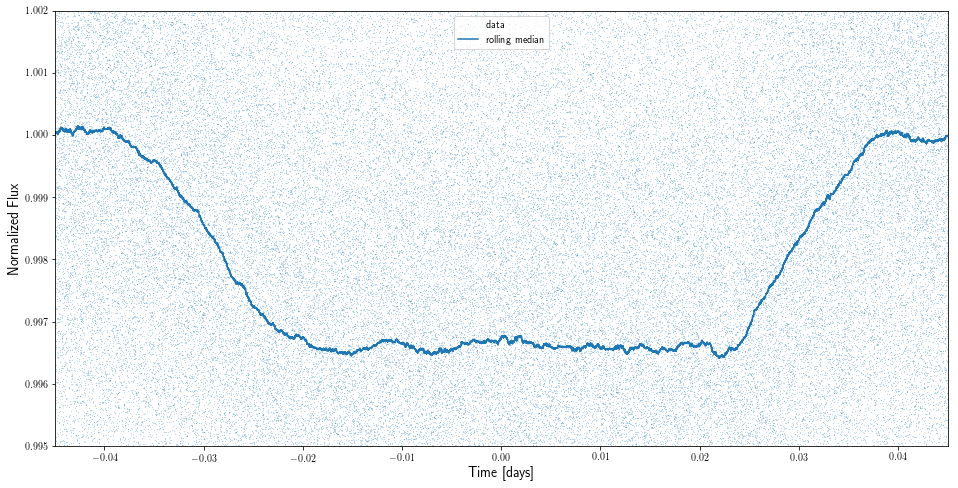

In [4]:
data = hd189.EclipseData(plot = True)

# Use **Gradients** to find Maximum Likelihood Solution

In [5]:
star, planet, system = hd189.instatiate_HD189(grad = True)

In [6]:
mlg = hd189.MaxLikeCartography(data.time, data.y, data.yerr, system, planet, N = 1, jac = True)

In [7]:
mlg.compute()

  0%|          | 0/1 [00:00<?, ?it/s]

Finding maximum likelihood solution with gradients from 1 random parameter initializations...


100%|██████████| 1/1 [02:31<00:00, 151.68s/it]


In [8]:
mlg.res

      fun: 0.5015234535383292
 hess_inv: array([[  9.27751255e+02,   2.15151167e+03,   2.80328709e+02,
         -3.19582331e+00],
       [  2.15151167e+03,   6.67100983e+03,   7.02693017e+02,
         -9.86514302e+00],
       [  2.80328709e+02,   7.02693017e+02,   1.70449282e+02,
         -1.05197784e+00],
       [ -3.19582331e+00,  -9.86514302e+00,  -1.05197784e+00,
          1.45989693e-02]])
      jac: array([  1.61293741e-06,  -5.88843480e-06,  -1.50332460e-05,
        -2.95931812e-03])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 142
      nit: 84
     njev: 123
   status: 2
  success: False
        x: array([ 0.11091122,  0.54093293,  0.15472956,  0.00206406])

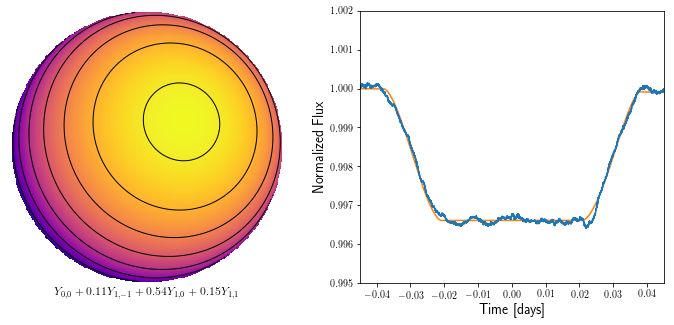

In [9]:
mlg.plot_ml_solution(data)

# Run MCMC

In [10]:
chain_path = "map_chain.npz"
grad = False
N = 2           # Number of ML fits
nsteps = 200    # Number of MCMC steps
nwalk = 40      # Number of MCMC walkers
std_ball = [0.01, 0.01, 0.01, 0.001]

# Load HD189 secondary eclipse data
data = hd189.EclipseData(plot = False)

# If there are no saved chains in this path 
if not os.path.exists(chain_path):
    
    # Use above results 
    results = mlg
    
    # Initialize system *without gradients*
    star, planet, system = hd189.instatiate_HD189(grad = False)
    
    # Initialize MCMC walkers *from maximum likelihood optimized solution*
    p0 = emcee.utils.sample_ball(results.res.x, std_ball, nwalk)
    
    # Run MCMC
    mcmc = hd189.MCMCCartography(data.time, data.y, data.yerr, system, planet, p0 = p0, 
                                 chain_path = chain_path)
    mcmc.run_mcmc(nsteps=nsteps)
    
    mcmc.save_chain()
        
else:
    
    # Read-in saved chain
    mcmc = hd189.MCMCCartography(data.time, data.y, data.yerr, system, planet, 
                                 chain_path = chain_path)

Loading MCMC chains from a saved state...


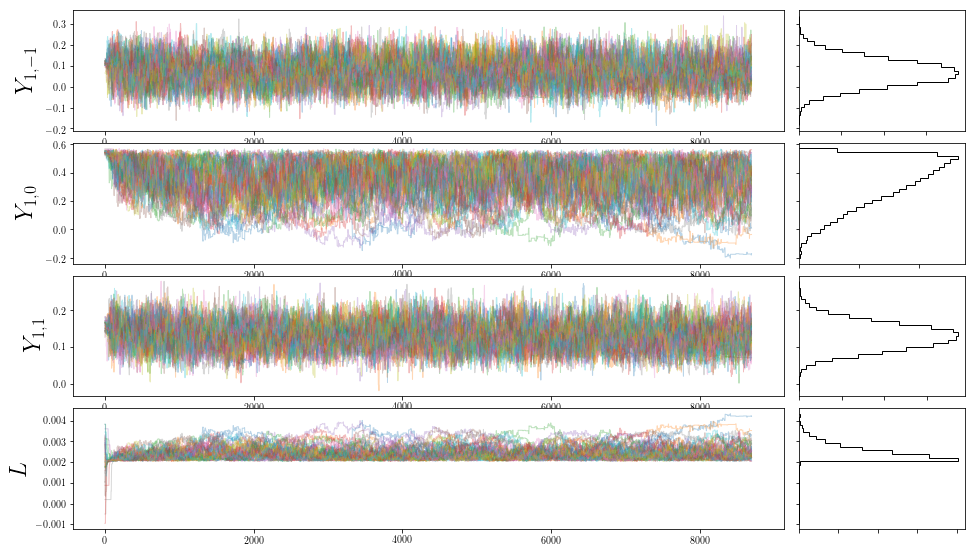

In [11]:
mcmc.plot_trace()

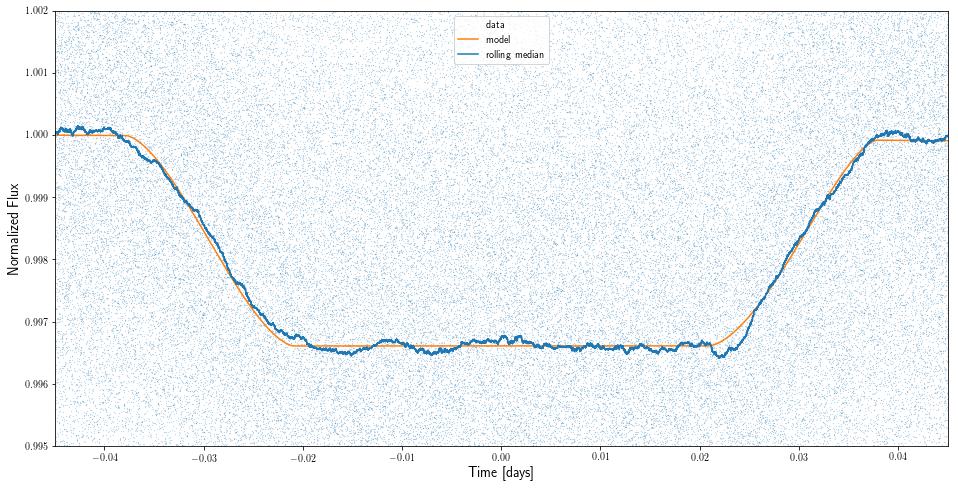

In [12]:
mcmc.apply_burnin(nburn = 2000)
mcmc.plot_fit(data)

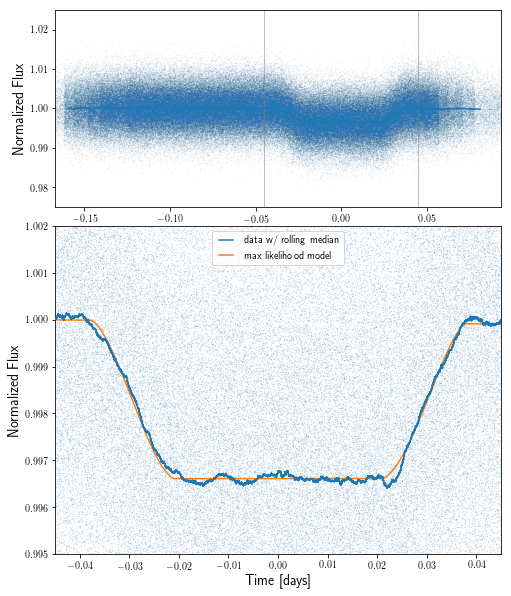

In [13]:
mcmc.plot_fit_full(data)

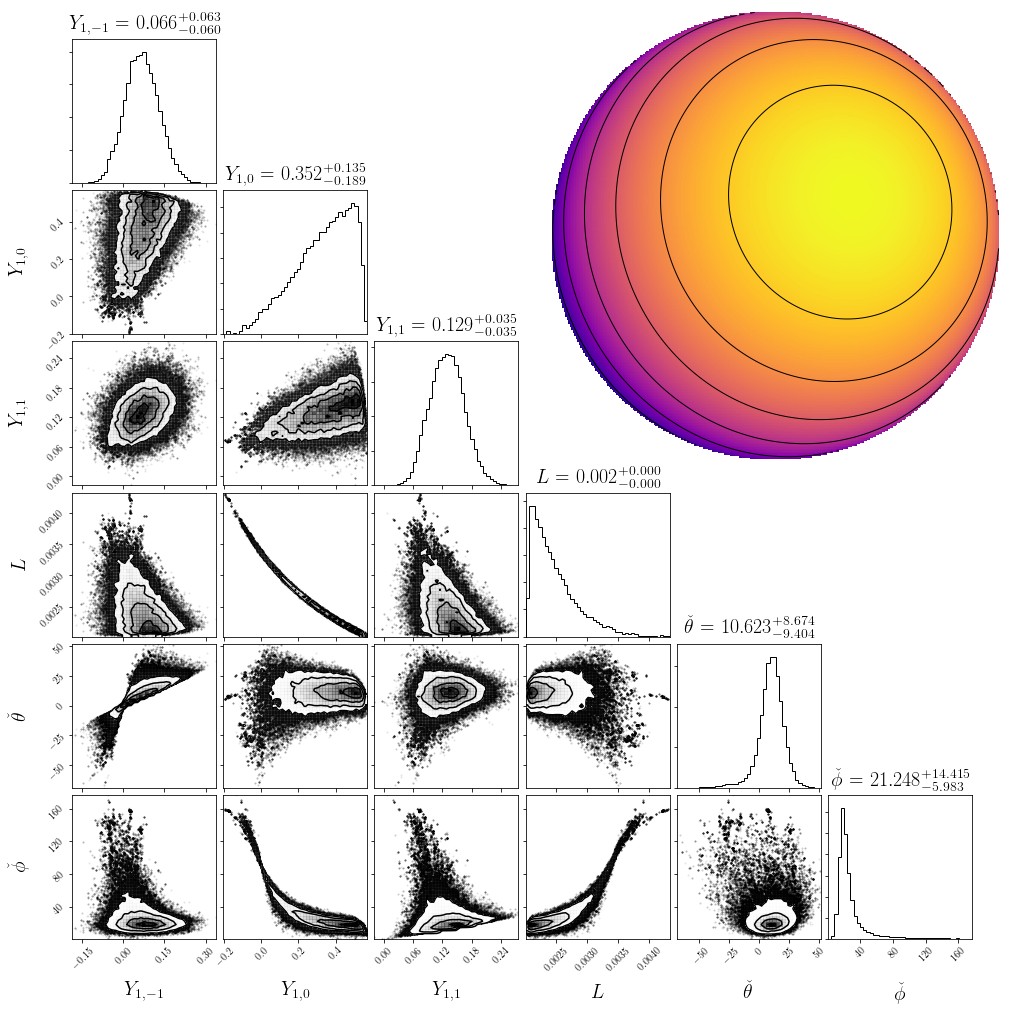

In [14]:
mcmc.get_hot_spot_samples()
mcmc.plot_corner_with_map()